# Document Clustering for Topic Modelling & Classification

## Manan Khandelwal 

# Preprocessing data


## 1. Fetch the raw data from the 20 newsgroup corpora

In [1]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

2024-08-28 08:50:11,458 : INFO : Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-08-28 08:50:11,459 : INFO : NumExpr defaulting to 8 threads.
C:\Users\manan\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\manan\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups

# we load both training and testing splits as our final project mainly focuses on the unsupervised setting. 
raw_dataset = fetch_20newsgroups(subset='all', shuffle=False)
print(raw_dataset.data[0])

From: cubbie@garnet.berkeley.edu (                               )
Subject: Re: Cubs behind Marlins? How?
Article-I.D.: agate.1pt592$f9a
Organization: University of California, Berkeley
Lines: 12
NNTP-Posting-Host: garnet.berkeley.edu


gajarsky@pilot.njin.net writes:

morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitcher)

       This season so far, Morgan and Guzman helped to lead the Cubs
       at top in ERA, even better than THE rotation at Atlanta.
       Cubs ERA at 0.056 while Braves at 0.059. We know it is early
       in the season, we Cubs fans have learned how to enjoy the
       short triumph while it is still there.



## 2. Clean the raw data

In [4]:
# Sklearn already implements an interface for this step.
dataset = fetch_20newsgroups(subset='all', shuffle=False, remove=('headers', 'footers', 'quotes'))
print(dataset.data[0])


morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitcher)


In [5]:
corpus = dataset.data # save as the raw docs
labels = dataset.target # labels for clustering evaluation or supervised tasks
print(len(corpus), len(labels))
print(labels)

18846 18846
[ 9  4 11 ...  4  6  7]


In [6]:
print(dataset.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


## Figuring out the targeted names

In [7]:
# Let's show the first 10 documents
for i in range(10):
    doc = corpus[i]
    category = dataset.target_names[labels[i]]
    print("The {}-th sent of {}: {}".format(i+1, category, doc))
    print("==================================================\n")

The 1-th sent of rec.sport.baseball: 
morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitcher)

The 2-th sent of comp.sys.mac.hardware: Well, I just got my Centris 610 yesterday.  It took just over two 
weeks from placing the order.  The dealer (Rutgers computer store) 
appologized because Apple made a substitution on my order.  I ordered
the one without ethernet, but they substituted one _with_ ethernet.
He wanted to know if that would be "alright with me"!!!  They must
be backlogged on Centri w/out ethernet so they're just shipping them
with!  

	Anyway, I'm very happy with the 610 with a few exceptions.  
Being nosy, I decided to open it up _before_ powering it on for the first
time.  The SCSI cable to the hard drive was only partially connected
(must have come loose in shipping).  No big deal, but I would have been
pissed if I tried to boot it and it wou

In [8]:
#finding frequency of each category 
targets, frequency = np.unique(dataset.target, return_counts=True)
targets, frequency

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([799, 973, 985, 982, 963, 988, 975, 990, 996, 994, 999, 991, 984,
        990, 987, 997, 910, 940, 775, 628], dtype=int64))

In [9]:
targets_str = np.array(dataset.target_names)
print(list(zip(targets_str, frequency)))

[('alt.atheism', 799), ('comp.graphics', 973), ('comp.os.ms-windows.misc', 985), ('comp.sys.ibm.pc.hardware', 982), ('comp.sys.mac.hardware', 963), ('comp.windows.x', 988), ('misc.forsale', 975), ('rec.autos', 990), ('rec.motorcycles', 996), ('rec.sport.baseball', 994), ('rec.sport.hockey', 999), ('sci.crypt', 991), ('sci.electronics', 984), ('sci.med', 990), ('sci.space', 987), ('soc.religion.christian', 997), ('talk.politics.guns', 910), ('talk.politics.mideast', 940), ('talk.politics.misc', 775), ('talk.religion.misc', 628)]


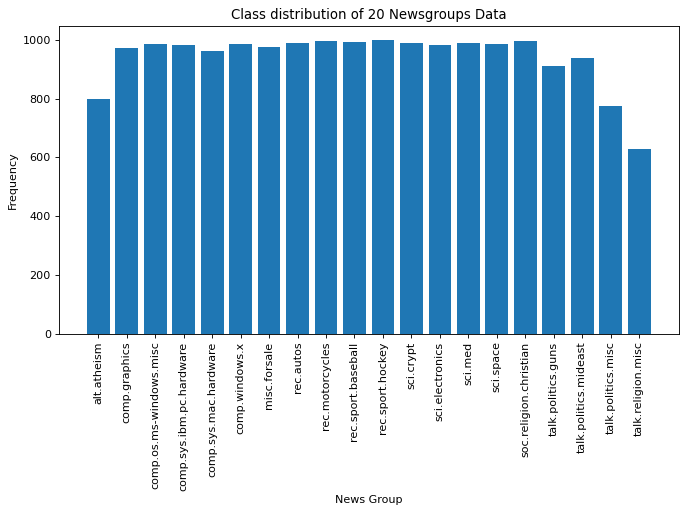

<Figure size 640x480 with 0 Axes>

In [10]:
# Training data class distribution
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(targets_str,frequency)
plt.xticks(rotation=90)
plt.title('Class distribution of 20 Newsgroups Data')
plt.xlabel('News Group')
plt.ylabel('Frequency')
plt.show()
plt.savefig('Class_distribution.png')

In [11]:
import pandas as pd
dataset_df = pd.DataFrame({'data': dataset.data, 'target': dataset.target})
dataset_df.head()

,data,target
0,\nmorgan and guzman will have era's 1 run high...,9
1,"Well, I just got my Centris 610 yesterday. It...",4
2,Archive-name: cryptography-faq/part10\nLast-mo...,11
3,To the best of my knowledge there aren't any p...,4
4,\n\nI think that domestication will change beh...,0


## 3. Tokenize sentences and clean

In [12]:
# So, appraently, we need do more Pre-processing step
from collections import defaultdict
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string
from pprint import pprint
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
import re
from nltk.corpus import stopwords
import nltk
# nltk.download('stopwords')

stopwords_extended = stopwords.words('english')
stopwords_extended.extend(['from', 'subject', 're', 'edu', 'use', 'know', 'make','also','say','take','come','want','look','even','find','thing','problem','need'
                 ,'first','much','many','light','call','last'])
stopwords_extended=set(stopwords_extended)
punctuation = set(string.punctuation) 
lemmatize = WordNetLemmatizer()

def pre_processing(docs):
    tokenizer = RegexpTokenizer(r"\w+(?:[-'+]\w+)*|\w+")
    en_stop = get_stop_words('en')
    en_stop.extend(['from', 'subject', 're', 'edu', 'use', 'know', 'make','also','say','take','come','want','look','even','find','thing','problem','need'
                 ,'first','much','many','light','call'])
    for doc in docs:
        raw_text = doc.lower()
        raw_text_stop = " ".join([i for i in raw_text.split() if i not in stopwords_extended])
        #punctuations
        raw_text_punc = raw_text_stop.translate(str.maketrans('', '', string.punctuation))
        #removing digits 
        raw_text = re.sub(r'\d+', '', raw_text_punc)
        
        #lemmatization
        #raw_text_lemma = " ".join(lemmatize.lemmatize(i) for i in raw_text.split())
        # tokenization
        tokens_text = tokenizer.tokenize(raw_text)
        # remove stopwords
        stopped_tokens_text = [i for i in tokens_text if not i in en_stop]
        # remoce digits and one-charcter word
        doc = [token for token in stopped_tokens_text if not token.isnumeric() and not token.isalnum()]
        doc = [token for token in stopped_tokens_text if len(token) > 3]
        # you could always add some new preprocessing here
        yield doc

doc1 = remove_stopwords(corpus[0])
doc2 = preprocess_string(corpus[0])
doc3 = next(pre_processing([corpus[0]]))
print(dataset.data[0])
print(doc1)
print("=========================")
print(doc2)
print(doc3)


morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitcher)
morgan guzman era's 1 run higher year, cubs idiots pitch harkey hibbard. castillo won't good (i think he's stud pitcher)
['morgan', 'guzman', 'era', 'run', 'higher', 'year', 'cub', 'idiot', 'pitch', 'harkei', 'hibbard', 'castillo', 'won', 'good', 'think', 'stud', 'pitcher']
['morgan', 'guzman', 'eras', 'higher', 'year', 'cubs', 'idiots', 'pitch', 'harkey', 'hibbard', 'castillo', 'good', 'think', 'stud', 'pitcher']


## 4. Build the Bigram, Trigram Models and Lemmatize

The key idea behind using bigrams and trigrams in machine learning is that they can help the model understand the structure and patterns in language

In [13]:
# Let's first get a new corpus by using one tokenization method above
# Also, for illustration purpose, we only take the first 1000 docs from the original corpus
corpus1 = list(pre_processing(corpus[:]))
print(len(corpus1))
print(corpus1[0])
# Then we build the vocab
freqs = defaultdict(int)
for doc in corpus1:
    for w in doc:
        freqs[w] += 1
print(len(freqs))
vocab = [w for w in freqs if freqs[w]>1]
print(len(vocab))

18846
['morgan', 'guzman', 'eras', 'higher', 'year', 'cubs', 'idiots', 'pitch', 'harkey', 'hibbard', 'castillo', 'good', 'think', 'stud', 'pitcher']
116403
47823


In [14]:
import gensim
# Build the bigram and trigram models
bigram = gensim.models.Phrases(corpus1, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[corpus1], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
# bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

2024-08-28 08:50:20,290 : INFO : collecting all words and their counts
2024-08-28 08:50:20,290 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2024-08-28 08:50:21,033 : INFO : PROGRESS: at sentence #10000, processed 805057 words and 697919 word types
2024-08-28 08:50:21,738 : INFO : collected 1166686 token types (unigram + bigrams) from a corpus of 1484265 words and 18846 sentences
2024-08-28 08:50:21,738 : INFO : merged Phrases<1166686 vocab, min_count=5, threshold=100, max_vocab_size=40000000>
2024-08-28 08:50:21,739 : INFO : Phrases lifecycle event {'msg': 'built Phrases<1166686 vocab, min_count=5, threshold=100, max_vocab_size=40000000> in 1.45s', 'datetime': '2024-08-28T08:50:21.739503', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'created'}
2024-08-28 08:50:21,740 : INFO : collecting all words and their counts
2024-08-28 08:50:21,740 : INFO : PROGRESS: at s

In [15]:
# This code is setting up functions for
# Combine common word pairs and trios.
# Reduce words to their base forms (like "running" to "run").
# Keep only certain types of words (like nouns and verbs).

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [16]:
# import subprocess
# subprocess.run(["python", "-m", "spacy", "download", "en_core_web_lg"])

In [17]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# Assuming 'corpus1' is a list of tokenized sentences
bigram = Phrases(corpus1, min_count=5, threshold=100) # Adjust min_count and threshold as needed
bigram_mod = Phraser(bigram)

# Function to make bigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Apply the bigram transformation
data_words_bigrams = make_bigrams(corpus1)


2024-08-28 08:50:26,066 : INFO : collecting all words and their counts
2024-08-28 08:50:26,067 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2024-08-28 08:50:27,278 : INFO : PROGRESS: at sentence #10000, processed 805057 words and 697919 word types
2024-08-28 08:50:28,293 : INFO : collected 1166686 token types (unigram + bigrams) from a corpus of 1484265 words and 18846 sentences
2024-08-28 08:50:28,293 : INFO : merged Phrases<1166686 vocab, min_count=5, threshold=100, max_vocab_size=40000000>
2024-08-28 08:50:28,293 : INFO : Phrases lifecycle event {'msg': 'built Phrases<1166686 vocab, min_count=5, threshold=100, max_vocab_size=40000000> in 2.23s', 'datetime': '2024-08-28T08:50:28.293090', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'created'}
2024-08-28 08:50:28,321 : INFO : exporting phrases from Phrases<1166686 vocab, min_count=5, threshold=100, max_vocab_s

In [18]:
import spacy
# Load the spaCy model (large model in this case)
nlp = spacy.load("en_core_web_lg", disable=['parser', 'ner'])
# Now you can use the 'nlp' object for processing text
doc = nlp("This is a sentence.")
# You can also disable specific components for efficiency if you're only interested in certain functionalities, like tokenization and tagging

In [19]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [20]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# Assuming 'corpus1' is a list of tokenized sentences
trigram = Phrases(corpus1, min_count=5, threshold=100) # Adjust min_count and threshold as needed
trigram_mod = Phraser(bigram)

# Function to make bigrams
def make_trigrams(texts):
    return [trigram_mod[doc] for doc in texts]

# Apply the bigram transformation
data_words_trigrams = make_trigrams(corpus1)
data_lemmatized_alt = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

2024-08-28 08:52:21,160 : INFO : collecting all words and their counts
2024-08-28 08:52:21,161 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2024-08-28 08:52:22,044 : INFO : PROGRESS: at sentence #10000, processed 805057 words and 697919 word types
2024-08-28 08:52:22,832 : INFO : collected 1166686 token types (unigram + bigrams) from a corpus of 1484265 words and 18846 sentences
2024-08-28 08:52:22,833 : INFO : merged Phrases<1166686 vocab, min_count=5, threshold=100, max_vocab_size=40000000>
2024-08-28 08:52:22,833 : INFO : Phrases lifecycle event {'msg': 'built Phrases<1166686 vocab, min_count=5, threshold=100, max_vocab_size=40000000> in 1.67s', 'datetime': '2024-08-28T08:52:22.833138', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'created'}
2024-08-28 08:52:22,860 : INFO : exporting phrases from Phrases<1166686 vocab, min_count=5, threshold=100, max_vocab_s

## 5. Exploratory Data Analysis

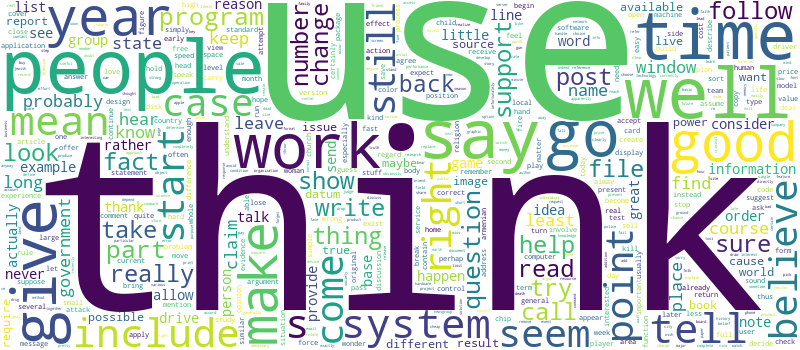

In [21]:
# Frequency of words in data_lemmatized data

# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed documnets together.
corpus_for_tf = []

for each_document in data_lemmatized:
    each_file = ""
    each_file += " ".join(each_token for each_token in each_document)
    corpus_for_tf.append(each_file)
long_string = ' '.join([sent for sent in corpus_for_tf ])

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=8, contour_color='steelblue',width=800, height=350)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

# The image shows the visual representation where the size of each word indicates how frequently it appears in the text

In [22]:
# wordcloud.to_file('wordcloud.png')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\manan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


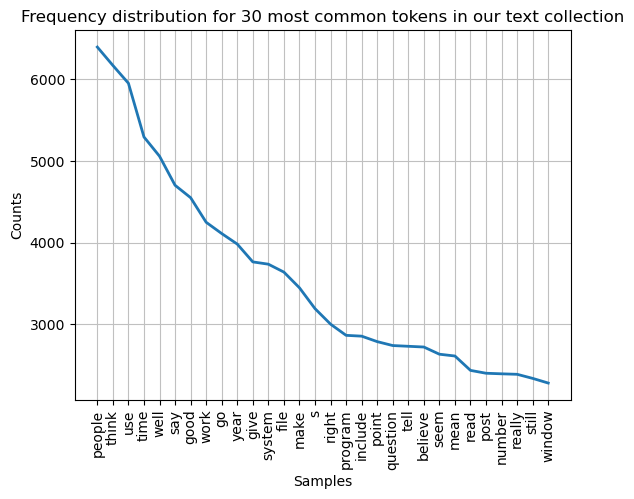

<AxesSubplot:title={'center':'Frequency distribution for 30 most common tokens in our text collection'}, xlabel='Samples', ylabel='Counts'>

In [23]:
from nltk import FreqDist
from nltk.tokenize import word_tokenize
nltk.download('punkt')
term_freq= FreqDist(word_tokenize(long_string))
term_freq.plot(30,title='Frequency distribution for 30 most common tokens in our text collection')

# creates a plot of the frequency distribution: It shows the 30 most common words in your text.

## 6. Build Vocab

In [24]:
from copy import deepcopy
import os
# A more efficient way is to use gensim.corpora
dictionary = corpora.Dictionary(data_lemmatized)
print(dictionary)

# Reduce the dict by filtering with document freq (DF)
dict1 = deepcopy(dictionary)
dict1.filter_extremes(no_below=15, no_above=0.5) # no_below and no_above are related to DF
print(dict1)

dict2 = deepcopy(dictionary)
dict2.filter_extremes(no_below=5, no_above=0.5, keep_n=2000)
print(dict2)

freqs = defaultdict(int)
for doc in data_lemmatized:
    for w in doc:
        freqs[w] += 1
        
# We can also use the freqs to filter dict with TF
low_tf_tokens = [w for w in freqs if freqs[w]<=10]
remove_ids = [dictionary.token2id[w] for w in low_tf_tokens]
print(len(remove_ids))
dictionary.filter_tokens(remove_ids)
dictionary.compactify()  # remove gaps in id sequence after words that were removed
print(dictionary)

# dictionray.cfs collects all the term freqs, similar to freqs
# Let's check if the new dictionary still has token with a tf <= 3
print(len([w for w in dictionary.cfs if dictionary.cfs[w]<=5]))

# Don't forget to save your vocab 
#dictionary.save('C:\\Users\\manan\\OneDrive\\Desktop\\newproject\\Company Project')

2024-08-28 08:54:08,471 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2024-08-28 08:54:08,918 : INFO : adding document #10000 to Dictionary(36962 unique tokens: ['cub', 'era', 'harkey', 'high', 'idiot']...)
2024-08-28 08:54:09,309 : INFO : built Dictionary(51511 unique tokens: ['cub', 'era', 'harkey', 'high', 'idiot']...) from 18846 documents (total 1126488 corpus positions)
2024-08-28 08:54:09,309 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(51511 unique tokens: ['cub', 'era', 'harkey', 'high', 'idiot']...) from 18846 documents (total 1126488 corpus positions)", 'datetime': '2024-08-28T08:54:09.309436', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'created'}
2024-08-28 08:54:09,468 : INFO : discarding 45707 tokens: [('era', 5), ('harkey', 2), ('stud', 9), ('afeature', 1), ('alright', 5), ('appologize', 2), ('backlogge', 1), ('centri', 3), ('dissappion

Dictionary(51511 unique tokens: ['cub', 'era', 'harkey', 'high', 'idiot']...)
Dictionary(5804 unique tokens: ['cub', 'high', 'idiot', 'pitch', 'pitcher']...)


2024-08-28 08:54:09,643 : INFO : discarding 49511 tokens: [('cub', 35), ('era', 5), ('harkey', 2), ('stud', 9), ('afeature', 1), ('alright', 5), ('annoying', 58), ('appologize', 2), ('backlogge', 1), ('centri', 3)]...
2024-08-28 08:54:09,643 : INFO : keeping 2000 tokens which were in no less than 5 and no more than 9423 (=50.0%) documents
2024-08-28 08:54:09,658 : INFO : resulting dictionary: Dictionary(2000 unique tokens: ['high', 'idiot', 'pitch', 'pitcher', 'think']...)


Dictionary(2000 unique tokens: ['high', 'idiot', 'pitch', 'pitcher', 'think']...)
43176
Dictionary(8335 unique tokens: ['cub', 'high', 'idiot', 'pitch', 'pitcher']...)
0


In [25]:
dictionary_alt = corpora.Dictionary(data_lemmatized_alt)
freqs = defaultdict(int)
for doc in data_lemmatized_alt:
    for w in doc:
        freqs[w] += 1
# You may also use the freqs to filter dict with TF
low_tf_tokens = [w for w in freqs if freqs[w]<=10]
remove_ids = [dictionary_alt.token2id[w] for w in low_tf_tokens]
print(len(remove_ids))
dictionary_alt.filter_tokens(remove_ids)
dictionary_alt.compactify()

2024-08-28 08:54:09,954 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2024-08-28 08:54:10,396 : INFO : adding document #10000 to Dictionary(36962 unique tokens: ['cub', 'era', 'harkey', 'high', 'idiot']...)
2024-08-28 08:54:10,781 : INFO : built Dictionary(51511 unique tokens: ['cub', 'era', 'harkey', 'high', 'idiot']...) from 18846 documents (total 1126488 corpus positions)
2024-08-28 08:54:10,781 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(51511 unique tokens: ['cub', 'era', 'harkey', 'high', 'idiot']...) from 18846 documents (total 1126488 corpus positions)", 'datetime': '2024-08-28T08:54:10.781679', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'created'}


43176


In [26]:
dictionary.save('dictionary.dict')
dict1.save('dict1.dict')
dict2.save('dict2.dict')
dictionary_alt.save('dictionary_alt.dict')

2024-08-28 08:54:11,029 : INFO : Dictionary lifecycle event {'fname_or_handle': 'dictionary.dict', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2024-08-28T08:54:11.029841', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'saving'}
2024-08-28 08:54:11,046 : INFO : saved dictionary.dict
2024-08-28 08:54:11,047 : INFO : Dictionary lifecycle event {'fname_or_handle': 'dict1.dict', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2024-08-28T08:54:11.047143', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'saving'}
2024-08-28 08:54:11,051 : INFO : saved dict1.dict
2024-08-28 08:54:11,052 : INFO : Dictionary lifecycle event {'fname_or_handle': 'dict2.dict', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datet

## 7. Vectorize the corpus

In [27]:
# my vocab/dictionary finally define my corpus
pprint(dictionary.token2id)

{'abandon': 1056,
 'abbreviation': 6306,
 'abide': 4887,
 'ability': 1057,
 'able': 549,
 'abolish': 3571,
 'abomination': 6766,
 'abort': 5497,
 'abortion': 5076,
 'abridge': 64,
 'abroad': 2385,
 'abruptly': 6052,
 'absence': 4999,
 'absent': 7074,
 'absolute': 2613,
 'absolute_truth': 4384,
 'absolutely': 1235,
 'absolutist': 7423,
 'absorb': 1385,
 'absorption': 7806,
 'abstinence': 5989,
 'abstract': 65,
 'abstraction': 6382,
 'absurd': 4763,
 'absurdity': 5865,
 'abundant': 7313,
 'abuse': 2026,
 'abuser': 6756,
 'abusive': 6510,
 'academic': 3785,
 'accelerate': 1386,
 'acceleration': 2636,
 'accelerator': 840,
 'accept': 593,
 'acceptable': 2327,
 'acceptance': 6383,
 'access': 293,
 'accessible': 3814,
 'accessory': 5969,
 'accident': 3271,
 'accidental': 7287,
 'accidental_death': 7389,
 'accidentally': 7388,
 'accidently': 7713,
 'accommodate': 1387,
 'accommodation': 8013,
 'accomodate': 5462,
 'accomodation': 4356,
 'accompany': 4096,
 'accomplish': 1388,
 'accomplishment'

In [28]:
corpus1_bows = [dictionary.doc2bow(doc) for doc in data_lemmatized]
corpora.MmCorpus.serialize('corpus.mm', corpus1_bows)
corpus2_bows = [dict2.doc2bow(doc) for doc in data_lemmatized]
corpora.MmCorpus.serialize('corpus2.mm', corpus2_bows)
print([len(corpus1_bows), len(corpus2_bows)])
print(corpus1_bows[0])
print(corpus2_bows[0])
# Let's see the text difference
print('Preprocess Text: {}'.format(' '.join([w for w in corpus1[0]])))
print('Using dictionary: {}'.format(' '.join([dictionary[wid] for wid,_ in corpus1_bows[0]])))
print('Using dict2: {}'.format(' '.join([dict2[wid] for wid,_ in corpus2_bows[0]])))

2024-08-28 08:54:11,641 : INFO : storing corpus in Matrix Market format to corpus.mm
2024-08-28 08:54:11,654 : INFO : saving sparse matrix to corpus.mm
2024-08-28 08:54:11,655 : INFO : PROGRESS: saving document #0
2024-08-28 08:54:11,689 : INFO : PROGRESS: saving document #1000
2024-08-28 08:54:11,735 : INFO : PROGRESS: saving document #2000
2024-08-28 08:54:11,774 : INFO : PROGRESS: saving document #3000
2024-08-28 08:54:11,811 : INFO : PROGRESS: saving document #4000
2024-08-28 08:54:11,845 : INFO : PROGRESS: saving document #5000
2024-08-28 08:54:11,877 : INFO : PROGRESS: saving document #6000
2024-08-28 08:54:11,911 : INFO : PROGRESS: saving document #7000
2024-08-28 08:54:11,948 : INFO : PROGRESS: saving document #8000
2024-08-28 08:54:11,983 : INFO : PROGRESS: saving document #9000
2024-08-28 08:54:12,019 : INFO : PROGRESS: saving document #10000
2024-08-28 08:54:12,053 : INFO : PROGRESS: saving document #11000
2024-08-28 08:54:12,086 : INFO : PROGRESS: saving document #12000
202

[18846, 18846]
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]
Preprocess Text: morgan guzman eras higher year cubs idiots pitch harkey hibbard castillo good think stud pitcher
Using dictionary: cub high idiot pitch pitcher stud think year
Using dict2: high idiot pitch pitcher think year


In [29]:
corpus_bows_df = [dict1.doc2bow(doc) for doc in data_lemmatized]
corpora.MmCorpus.serialize('corpus_df.mm', corpus_bows_df)
corpus_bows_trigram = [dictionary_alt.doc2bow(doc) for doc in data_lemmatized]
corpora.MmCorpus.serialize('corpus_trigram.mm', corpus_bows_trigram)

print([len(corpus_bows_df)])
print(corpus_bows_df[0])

# Let's see the text difference
print('Preprocess Text: {}'.format(' '.join([w for w in corpus1[0]])))
print('Using dictionary: {}'.format(' '.join([dictionary[wid] for wid,_ in corpus_bows_df[0]])))
print('Using dict2: {}'.format(' '.join([dict2[wid] for wid,_ in corpus_bows_trigram[0]])))

2024-08-28 08:54:13,952 : INFO : storing corpus in Matrix Market format to corpus_df.mm
2024-08-28 08:54:13,953 : INFO : saving sparse matrix to corpus_df.mm
2024-08-28 08:54:13,954 : INFO : PROGRESS: saving document #0
2024-08-28 08:54:13,987 : INFO : PROGRESS: saving document #1000
2024-08-28 08:54:14,023 : INFO : PROGRESS: saving document #2000
2024-08-28 08:54:14,056 : INFO : PROGRESS: saving document #3000
2024-08-28 08:54:14,090 : INFO : PROGRESS: saving document #4000
2024-08-28 08:54:14,121 : INFO : PROGRESS: saving document #5000
2024-08-28 08:54:14,152 : INFO : PROGRESS: saving document #6000
2024-08-28 08:54:14,186 : INFO : PROGRESS: saving document #7000
2024-08-28 08:54:14,219 : INFO : PROGRESS: saving document #8000
2024-08-28 08:54:14,249 : INFO : PROGRESS: saving document #9000
2024-08-28 08:54:14,284 : INFO : PROGRESS: saving document #10000
2024-08-28 08:54:14,316 : INFO : PROGRESS: saving document #11000
2024-08-28 08:54:14,346 : INFO : PROGRESS: saving document #120

[18846]
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]
Preprocess Text: morgan guzman eras higher year cubs idiots pitch harkey hibbard castillo good think stud pitcher
Using dictionary: cub high idiot pitch pitcher stud think
Using dict2: high idiot pitch pitcher think year anyway apple


## Finally, refine the corpus with the vocab

It's iterating through each document, this effectively filters out any words that aren't in my dictionary.

In [30]:
new_corpus = [[w for w in doc if w in dictionary.token2id] for doc in data_lemmatized]
print(len(new_corpus))
print(data_lemmatized[0]) 
print(new_corpus[0]) # If the word is in the dictionary, it keeps it. If not, it leaves it out.

18846
['era', 'high', 'year', 'cub', 'idiot', 'pitch', 'harkey', 'think', 'stud', 'pitcher']
['high', 'year', 'cub', 'idiot', 'pitch', 'think', 'stud', 'pitcher']


In [31]:
#from top 2000 features 
new_corpus2 = [[w for w in doc if w in dict2.token2id] for doc in data_lemmatized]
print(len(new_corpus2))
print(data_lemmatized[0])
print(new_corpus2[0])

18846
['era', 'high', 'year', 'cub', 'idiot', 'pitch', 'harkey', 'think', 'stud', 'pitcher']
['high', 'year', 'idiot', 'pitch', 'think', 'pitcher']


In [32]:
new_corpus_df = [[w for w in doc if w in dict1.token2id] for doc in data_lemmatized]
new_corpus_trigram = [[w for w in doc if w in dictionary_alt.token2id] for doc in data_lemmatized_alt]

## 8. LDA Representation


In [61]:
from gensim import models
lda = models.LdaModel(corpus1_bows, id2word=dictionary, num_topics=17,alpha=0.01,
                                           eta=0.9, random_state=42);

from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

2024-08-28 10:42:04,745 : INFO : using serial LDA version on this node
2024-08-28 10:42:04,772 : INFO : running online (single-pass) LDA training, 17 topics, 1 passes over the supplied corpus of 18846 documents, updating model once every 2000 documents, evaluating perplexity every 18846 documents, iterating 50x with a convergence threshold of 0.001000
2024-08-28 10:42:04,773 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-08-28 10:42:04,775 : INFO : PROGRESS: pass 0, at document #2000/18846
2024-08-28 10:42:07,098 : INFO : merging changes from 2000 documents into a model of 18846 documents
2024-08-28 10:42:07,109 : INFO : topic #2 (0.010): 0.009*"use" + 0.007*"time" + 0.007*"good" + 0.007*"well" + 0.006*"play" + 0.005*"go" + 0.005*"say" + 0.004*"right" + 0.004*"make" + 0.004*"game"
2024-08-28 10:42:07,112 : INFO : topic #7 (0.010): 0.007*"use" + 0.006*"people" + 0.005*"think" + 0.005*"time" + 0.00

2024-08-28 10:42:17,241 : INFO : topic diff=0.235367, rho=0.408248
2024-08-28 10:42:17,244 : INFO : PROGRESS: pass 0, at document #14000/18846
2024-08-28 10:42:19,082 : INFO : merging changes from 2000 documents into a model of 18846 documents
2024-08-28 10:42:19,093 : INFO : topic #11 (0.010): 0.006*"helmet" + 0.005*"flight" + 0.004*"part" + 0.003*"space" + 0.003*"black" + 0.003*"motor" + 0.003*"shuttle" + 0.003*"ground" + 0.003*"white" + 0.003*"cover"
2024-08-28 10:42:19,095 : INFO : topic #1 (0.010): 0.015*"people" + 0.014*"think" + 0.012*"say" + 0.008*"go" + 0.008*"believe" + 0.007*"time" + 0.007*"well" + 0.006*"make" + 0.006*"s" + 0.005*"tell"
2024-08-28 10:42:19,097 : INFO : topic #12 (0.010): 0.008*"people" + 0.007*"state" + 0.006*"year" + 0.006*"right" + 0.006*"government" + 0.005*"president" + 0.005*"work" + 0.005*"issue" + 0.004*"program" + 0.004*"think"
2024-08-28 10:42:19,099 : INFO : topic #8 (0.010): 0.018*"card" + 0.012*"drive" + 0.011*"price" + 0.011*"driver" + 0.010*"t


Coherence Score:  0.48281466371784004


## 9. Hyperparameter Tuning


In [34]:
lda = models.LdaModel(corpus1_bows, id2word=dictionary, num_topics=20,alpha=0.01,
                                           eta=0.9, random_state=42);

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

2024-08-28 08:54:43,164 : INFO : using serial LDA version on this node
2024-08-28 08:54:43,178 : INFO : running online (single-pass) LDA training, 20 topics, 1 passes over the supplied corpus of 18846 documents, updating model once every 2000 documents, evaluating perplexity every 18846 documents, iterating 50x with a convergence threshold of 0.001000
2024-08-28 08:54:43,178 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-08-28 08:54:43,179 : INFO : PROGRESS: pass 0, at document #2000/18846
2024-08-28 08:54:44,074 : INFO : merging changes from 2000 documents into a model of 18846 documents
2024-08-28 08:54:44,080 : INFO : topic #9 (0.010): 0.006*"work" + 0.006*"think" + 0.006*"people" + 0.006*"use" + 0.005*"give" + 0.004*"well" + 0.004*"say" + 0.004*"time" + 0.004*"system" + 0.004*"good"
2024-08-28 08:54:44,081 : INFO : topic #8 (0.010): 0.005*"well" + 0.005*"time" + 0.005*"thank" + 0.005*"post" +

2024-08-28 08:54:48,408 : INFO : PROGRESS: pass 0, at document #14000/18846
2024-08-28 08:54:49,188 : INFO : merging changes from 2000 documents into a model of 18846 documents
2024-08-28 08:54:49,195 : INFO : topic #12 (0.010): 0.007*"group" + 0.007*"issue" + 0.006*"people" + 0.006*"program" + 0.006*"work" + 0.006*"president" + 0.005*"state" + 0.005*"year" + 0.005*"service" + 0.004*"information"
2024-08-28 08:54:49,196 : INFO : topic #13 (0.010): 0.008*"cause" + 0.007*"cancer" + 0.006*"treatment" + 0.006*"water" + 0.006*"patient" + 0.005*"time" + 0.005*"effect" + 0.004*"drug" + 0.004*"vitamin" + 0.004*"doctor"
2024-08-28 08:54:49,197 : INFO : topic #9 (0.010): 0.007*"word" + 0.007*"moral" + 0.007*"mean" + 0.006*"pitcher" + 0.006*"pitch" + 0.005*"think" + 0.005*"scripture" + 0.004*"give" + 0.004*"base" + 0.004*"use"
2024-08-28 08:54:49,198 : INFO : topic #8 (0.010): 0.017*"card" + 0.016*"thank" + 0.012*"email" + 0.011*"price" + 0.010*"sell" + 0.010*"good" + 0.008*"driver" + 0.008*"post


Coherence Score:  0.5074604629398777


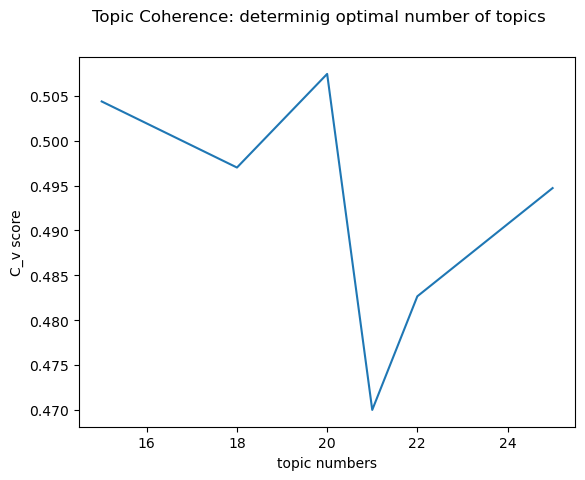

In [35]:
plt.plot([15, 18, 20, 21, 22, 25], [0.50439,0.49702,0.50746, 0.46999, 0.48266, 0.49473])
plt.ylabel('C_v score')
plt.xlabel('topic numbers')
plt.suptitle('Topic Coherence: determinig optimal number of topics')
plt.show()

we achieved model coherence to be approx 0.50746 by experimenting with different num_topics, alpha and beta values.

In [36]:
#running the model with all features 
corpus_lda = lda[corpus1_bows]

In [37]:
topic_assignments= lda.get_document_topics(corpus1_bows, minimum_probability=0, minimum_phi_value=None, per_word_topics=False)
lda_matirx = [ [entry[1] for entry in doc] for doc in topic_assignments ]

## 9. Clustering

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score 
import statistics 

In [39]:
km = KMeans(n_clusters = 20, init="random", n_init=20)

In [40]:
km.fit_predict(lda_matirx)

array([14,  2,  0, ..., 13,  4, 18])

In [41]:
print(nmi_score(labels,km.labels_))

0.3036837710362404


## Running LDA with top 2000 features


In [42]:
#running the model with top 2000 features 
lda2 = models.LdaModel(corpus2_bows, id2word=dict2, num_topics=18, alpha=0.01,
                                           eta=0.9, random_state=42)

# Compute Coherence Score
coherence_model_lda2 = CoherenceModel(model=lda2, texts=data_lemmatized, dictionary=dict2, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

2024-08-28 08:55:18,277 : INFO : using serial LDA version on this node
2024-08-28 08:55:18,281 : INFO : running online (single-pass) LDA training, 18 topics, 1 passes over the supplied corpus of 18846 documents, updating model once every 2000 documents, evaluating perplexity every 18846 documents, iterating 50x with a convergence threshold of 0.001000
2024-08-28 08:55:18,281 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-08-28 08:55:18,282 : INFO : PROGRESS: pass 0, at document #2000/18846
2024-08-28 08:55:19,035 : INFO : merging changes from 2000 documents into a model of 18846 documents
2024-08-28 08:55:19,036 : INFO : topic #14 (0.010): 0.012*"use" + 0.008*"people" + 0.008*"think" + 0.008*"well" + 0.007*"good" + 0.005*"chip" + 0.005*"include" + 0.005*"follow" + 0.005*"year" + 0.005*"system"
2024-08-28 08:55:19,037 : INFO : topic #11 (0.010): 0.011*"think" + 0.008*"use" + 0.008*"time" + 0.007*"

2024-08-28 08:55:22,595 : INFO : PROGRESS: pass 0, at document #14000/18846
2024-08-28 08:55:23,237 : INFO : merging changes from 2000 documents into a model of 18846 documents
2024-08-28 08:55:23,239 : INFO : topic #6 (0.010): 0.022*"good" + 0.017*"well" + 0.017*"game" + 0.014*"year" + 0.014*"time" + 0.013*"think" + 0.011*"s" + 0.010*"really" + 0.008*"hear" + 0.008*"get"
2024-08-28 08:55:23,240 : INFO : topic #13 (0.010): 0.019*"book" + 0.017*"list" + 0.015*"email" + 0.013*"send" + 0.012*"copy" + 0.010*"use" + 0.010*"print" + 0.009*"page" + 0.009*"information" + 0.009*"mail"
2024-08-28 08:55:23,241 : INFO : topic #1 (0.010): 0.019*"card" + 0.013*"report" + 0.012*"study" + 0.011*"lose" + 0.010*"food" + 0.007*"use" + 0.007*"helmet" + 0.007*"armenian" + 0.007*"number" + 0.006*"search"
2024-08-28 08:55:23,241 : INFO : topic #5 (0.010): 0.013*"use" + 0.011*"point" + 0.010*"power" + 0.008*"good" + 0.008*"work" + 0.008*"time" + 0.007*"line" + 0.007*"cause" + 0.006*"area" + 0.006*"book"
2024-


Coherence Score:  0.5074604629398777


In [43]:
corpus_lda2 = lda[corpus2_bows]

In [44]:
topic_assignments= lda2.get_document_topics(corpus2_bows, minimum_probability=0, minimum_phi_value=None, per_word_topics=False)
lda2_matirx = [ [entry[1] for entry in doc] for doc in topic_assignments ]

In [45]:
#clustering 
km = KMeans(n_clusters = 20, init="random", n_init=20)
km.fit_predict(lda2_matirx)
print(nmi_score(labels,km.labels_))

0.25294463137902656


In [46]:
lda.save('lda_topic.model')
lda2.save('lda2_topic.model')

2024-08-28 08:55:32,920 : INFO : LdaState lifecycle event {'fname_or_handle': 'lda_topic.model.state', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2024-08-28T08:55:32.920495', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'saving'}
2024-08-28 08:55:32,922 : INFO : saved lda_topic.model.state
2024-08-28 08:55:32,930 : INFO : LdaModel lifecycle event {'fname_or_handle': 'lda_topic.model', 'separately': "['expElogbeta', 'sstats']", 'sep_limit': 10485760, 'ignore': ['state', 'dispatcher', 'id2word'], 'datetime': '2024-08-28T08:55:32.930466', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'saving'}
2024-08-28 08:55:32,931 : INFO : storing np array 'expElogbeta' to lda_topic.model.expElogbeta.npy
2024-08-28 08:55:32,933 : INFO : not storing attribute state
2

## Visualizing the LDA topics
Displaying or Visualizing the topic modelling performed through LDA 

In [47]:
import pyLDAvis.gensim
import gensim
pyLDAvis.enable_notebook()

In [48]:
d = gensim.corpora.Dictionary.load('dictionary.dict')
c = gensim.corpora.MmCorpus('corpus.mm')
lda = gensim.models.LdaModel.load('lda_topic.model')

2024-08-28 08:55:33,029 : INFO : loading Dictionary object from dictionary.dict
2024-08-28 08:55:33,045 : INFO : Dictionary lifecycle event {'fname': 'dictionary.dict', 'datetime': '2024-08-28T08:55:33.045513', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'loaded'}
2024-08-28 08:55:33,053 : INFO : loaded corpus index from corpus.mm.index
2024-08-28 08:55:33,054 : INFO : initializing cython corpus reader from corpus.mm
2024-08-28 08:55:33,062 : INFO : accepted corpus with 18846 documents, 8335 features, 705868 non-zero entries
2024-08-28 08:55:33,063 : INFO : loading LdaModel object from lda_topic.model
2024-08-28 08:55:33,072 : INFO : loading expElogbeta from lda_topic.model.expElogbeta.npy with mmap=None
2024-08-28 08:55:33,078 : INFO : setting ignored attribute state to None
2024-08-28 08:55:33,079 : INFO : setting ignored attribute dispatcher to None
2024-08-28 08:55:33,079 : INFO :

In [49]:
data = pyLDAvis.gensim.prepare(lda, c, d)
data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.051881  0.161489       1        1  16.259358
15     0.043726  0.100550       2        1  11.830644
3     -0.206326  0.001859       3        1  11.247996
7     -0.036246  0.059332       4        1   7.381995
10    -0.137151 -0.022315       5        1   6.967929
12    -0.003688  0.020458       6        1   5.982716
2     -0.002406  0.078474       7        1   5.566068
0      0.069860  0.077304       8        1   5.353485
5      0.118883  0.047322       9        1   5.209861
8     -0.128707  0.001465      10        1   4.798586
4     -0.130908  0.000946      11        1   4.347155
17     0.004389 -0.025463      12        1   3.508509
13     0.040142 -0.008833      13        1   3.421762
14     0.008287 -0.004165      14        1   2.763345
16     0.057950 -0.033286      15        1   2.228757
19     0.087934 -0.067024      16        1   1.377709
9      0.043182 -0.025058      17        1   0.673261
6      0.030814 -0.135563      18        1   0.615796
11     0.046822 -0.135581      19        1   0.345980
18     0.041561 -0.091911      20        1   0.119089, topic_info=            Term         Freq        Total Category  logprob  loglift
143         file  3537.000000  3537.000000  Default  30.0000  30.0000
516         game  2085.000000  2085.000000  Default  29.0000  29.0000
1633       image  2434.000000  2434.000000  Default  28.0000  28.0000
2387    armenian  1176.000000  1176.000000  Default  27.0000  27.0000
826   government  1863.000000  1863.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
469       people     1.661636  5451.820712  Topic20  -6.6021  -1.3628
270       system     1.513458  3198.400327  Topic20  -6.6955  -0.9230
2328        card     1.242801  1070.159155  Topic20  -6.8925  -0.0251
153         good     1.273607  4089.007805  Topic20  -6.8681  -1.3412
288         well     1.159060  4720.643737  Topic20  -6.9623  -1.5790

[1235 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2613      1  0.020509  absolute
2613      2  0.728072  absolute
2613      3  0.066654  absolute
2613      4  0.010255  absolute
2613      5  0.025636  absolute
...     ...       ...       ...
5903     13  0.036865    zipper
5903     14  0.036865    zipper
5903     15  0.036865    zipper
5903     16  0.036865    zipper
5903     19  0.073731    zipper

[16659 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 16, 4, 8, 11, 13, 3, 1, 6, 9, 5, 18, 14, 15, 17, 20, 10, 7, 12, 19])

In [50]:
pyLDAvis.save_html(data,'LDA_My_Company_Model.html')

In [51]:
d = gensim.corpora.Dictionary.load('dict2.dict')
c = gensim.corpora.MmCorpus('corpus2.mm')
lda = gensim.models.LdaModel.load('lda2_topic.model')

2024-08-28 08:55:42,361 : INFO : loading Dictionary object from dict2.dict
2024-08-28 08:55:42,368 : INFO : Dictionary lifecycle event {'fname': 'dict2.dict', 'datetime': '2024-08-28T08:55:42.368833', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'loaded'}
2024-08-28 08:55:42,377 : INFO : loaded corpus index from corpus2.mm.index
2024-08-28 08:55:42,378 : INFO : initializing cython corpus reader from corpus2.mm
2024-08-28 08:55:42,387 : INFO : accepted corpus with 18846 documents, 2000 features, 561602 non-zero entries
2024-08-28 08:55:42,388 : INFO : loading LdaModel object from lda2_topic.model
2024-08-28 08:55:42,397 : INFO : loading expElogbeta from lda2_topic.model.expElogbeta.npy with mmap=None
2024-08-28 08:55:42,404 : INFO : setting ignored attribute state to None
2024-08-28 08:55:42,404 : INFO : setting ignored attribute dispatcher to None
2024-08-28 08:55:42,405 : INFO : setti

In [52]:
data = pyLDAvis.gensim.prepare(lda, c, d)
data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.086296  0.090777       1        1  14.374859
2     -0.201313  0.005054       2        1  11.705276
8      0.105697  0.115346       3        1   9.023257
0      0.112402  0.030390       4        1   7.430328
16     0.147696 -0.032707       5        1   6.861922
6      0.093953 -0.101978       6        1   5.419671
14    -0.094066  0.082640       7        1   5.270055
13    -0.136968  0.027821       8        1   4.747220
9      0.000411  0.110299       9        1   4.704918
7     -0.030464 -0.077124      10        1   4.469687
17    -0.055730  0.032455      11        1   4.141663
5     -0.001503 -0.044491      12        1   4.080248
15    -0.096872 -0.095979      13        1   3.940666
12     0.092846 -0.084054      14        1   3.296845
10    -0.008059 -0.086818      15        1   3.198533
3     -0.009267 -0.051766      16        1   2.555919
11    -0.007539 -0.004731      17        1   2.511865
1      0.002481  0.084866      18        1   2.267068, topic_info=          Term         Freq        Total Category  logprob  loglift
1089     image  2667.000000  2667.000000  Default  30.0000  30.0000
102       file  3694.000000  3694.000000  Default  29.0000  29.0000
393       game  2023.000000  2023.000000  Default  28.0000  28.0000
698      drive  1865.000000  1865.000000  Default  27.0000  27.0000
39       price  1330.000000  1330.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1317  increase    88.975712   774.473644  Topic18  -5.3576   1.6229
115    include   108.095629  2678.773721  Topic18  -5.1630   0.5766
585     result    91.082023  1212.195820  Topic18  -5.3343   1.1983
121      issue    91.326988  1395.578318  Topic18  -5.3316   1.0601
265       give    91.349349  3766.737702  Topic18  -5.3313   0.0674

[1001 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
210       1  0.011466  access
210       2  0.406400  access
210       3  0.006370  access
210       4  0.049685  access
210       5  0.003822  access
...     ...       ...     ...
5        14  0.129141    year
5        15  0.055884    year
5        16  0.018531    year
5        17  0.002027    year
5        18  0.020558    year

[13122 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 9, 1, 17, 7, 15, 14, 10, 8, 18, 6, 16, 13, 11, 4, 12, 2])

In [53]:
pyLDAvis.save_html(data,'LDA2_My_Company_Model.html')

In [54]:
from gensim import models
import pandas as pd

# Assuming lda is your trained LDA model
topics = lda.show_topics(num_topics=4, num_words=10, formatted=False)

# Extract top words for each topic and create topic names
top_topic_names = []
for topic in topics:
    topic_id, topic_words = topic
    top_words = [word for word, prob in topic_words]
    topic_name = "Topic {}: {}".format(topic_id, ", ".join(top_words[:4]))  # Taking top 4 words for naming
    top_topic_names.append(topic_name)

# Print the top topic names
for name in top_topic_names:
    print(name)

# Optionally, store these in a DataFrame for better presentation
df_topics = pd.DataFrame(top_topic_names, columns=["Top 4 Topics"])
print(df_topics)


Topic 15: drive, system, disk, work
Topic 4: people, believe, think, word
Topic 3: price, sell, drug, apple
Topic 17: space, planet, system, year
                            Top 4 Topics
0    Topic 15: drive, system, disk, work
1  Topic 4: people, believe, think, word
2      Topic 3: price, sell, drug, apple
3  Topic 17: space, planet, system, year


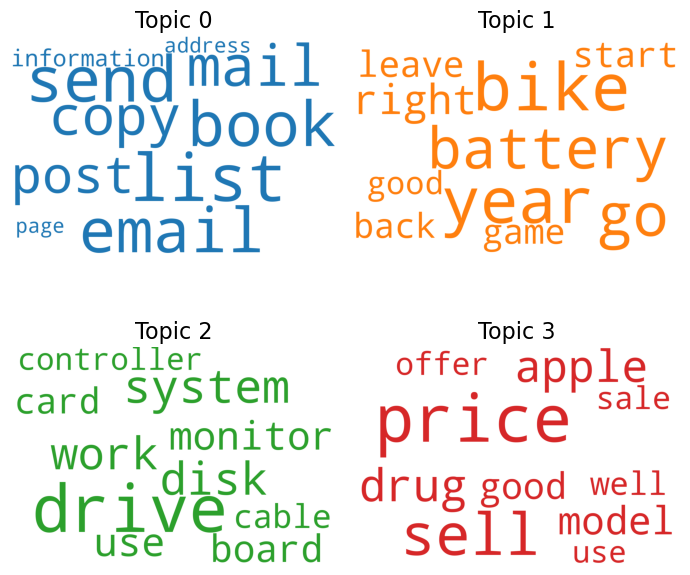

In [55]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=1500,
                  height=1000,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(7,7), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
# plt.savefig('lda_wordcloud.png')

## Performing LDA on remaining features

In [56]:
#using dict1 which had only gone through document frequency preprocesssing and not term frequency 
lda3 = models.LdaModel(corpus_bows_df, id2word=dict1, num_topics=20,alpha=0.01,
                                           eta=0.9, random_state=42);
#Compute Model Perplexity and Coherence Score
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda3, texts=data_lemmatized, dictionary=dict1, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
#running the model with all features 
corpus_lda = lda[corpus_bows_df]
lda3.save('lda3_topic.model')

2024-08-28 08:55:52,579 : INFO : using serial LDA version on this node
2024-08-28 08:55:52,589 : INFO : running online (single-pass) LDA training, 20 topics, 1 passes over the supplied corpus of 18846 documents, updating model once every 2000 documents, evaluating perplexity every 18846 documents, iterating 50x with a convergence threshold of 0.001000
2024-08-28 08:55:52,590 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-08-28 08:55:52,591 : INFO : PROGRESS: pass 0, at document #2000/18846
2024-08-28 08:55:53,576 : INFO : merging changes from 2000 documents into a model of 18846 documents
2024-08-28 08:55:53,582 : INFO : topic #3 (0.010): 0.008*"time" + 0.007*"well" + 0.006*"good" + 0.006*"system" + 0.006*"think" + 0.005*"use" + 0.005*"work" + 0.004*"year" + 0.004*"point" + 0.004*"program"
2024-08-28 08:55:53,583 : INFO : topic #11 (0.010): 0.008*"people" + 0.006*"use" + 0.006*"well" + 0.005*"thi

2024-08-28 08:55:57,818 : INFO : topic diff=0.244158, rho=0.408248
2024-08-28 08:55:57,819 : INFO : PROGRESS: pass 0, at document #14000/18846
2024-08-28 08:55:58,613 : INFO : merging changes from 2000 documents into a model of 18846 documents
2024-08-28 08:55:58,619 : INFO : topic #6 (0.010): 0.009*"exist" + 0.007*"good" + 0.007*"believe" + 0.006*"well" + 0.006*"belief" + 0.006*"use" + 0.006*"think" + 0.006*"point" + 0.005*"atheist" + 0.005*"question"
2024-08-28 08:55:58,620 : INFO : topic #14 (0.010): 0.009*"drug" + 0.008*"rate" + 0.007*"insurance" + 0.007*"high" + 0.005*"well" + 0.004*"private" + 0.004*"cancer" + 0.004*"good" + 0.004*"state" + 0.004*"use"
2024-08-28 08:55:58,620 : INFO : topic #3 (0.010): 0.012*"drive" + 0.011*"use" + 0.011*"card" + 0.010*"work" + 0.008*"system" + 0.008*"thank" + 0.007*"email" + 0.007*"price" + 0.007*"good" + 0.006*"sell"
2024-08-28 08:55:58,622 : INFO : topic #19 (0.010): 0.017*"post" + 0.013*"group" + 0.008*"newsgroup" + 0.008*"read" + 0.007*"priv

2024-08-28 08:56:19,909 : INFO : storing np array 'expElogbeta' to lda3_topic.model.expElogbeta.npy
2024-08-28 08:56:19,911 : INFO : not storing attribute state
2024-08-28 08:56:19,911 : INFO : not storing attribute dispatcher
2024-08-28 08:56:19,912 : INFO : not storing attribute id2word
2024-08-28 08:56:19,914 : INFO : saved lda3_topic.model



Coherence Score:  0.5188546308900394


In [57]:
d = gensim.corpora.Dictionary.load('dict1.dict')
c = gensim.corpora.MmCorpus('corpus_df.mm')
lda = gensim.models.LdaModel.load('lda3_topic.model')

data = pyLDAvis.gensim.prepare(lda, c, d)
data

2024-08-28 08:56:19,930 : INFO : loading Dictionary object from dict1.dict
2024-08-28 08:56:19,943 : INFO : Dictionary lifecycle event {'fname': 'dict1.dict', 'datetime': '2024-08-28T08:56:19.943263', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'loaded'}
2024-08-28 08:56:19,955 : INFO : loaded corpus index from corpus_df.mm.index
2024-08-28 08:56:19,956 : INFO : initializing cython corpus reader from corpus_df.mm
2024-08-28 08:56:19,963 : INFO : accepted corpus with 18846 documents, 5804 features, 680367 non-zero entries
2024-08-28 08:56:19,963 : INFO : loading LdaModel object from lda3_topic.model
2024-08-28 08:56:19,970 : INFO : loading expElogbeta from lda3_topic.model.expElogbeta.npy with mmap=None
2024-08-28 08:56:19,978 : INFO : setting ignored attribute state to None
2024-08-28 08:56:19,979 : INFO : setting ignored attribute dispatcher to None
2024-08-28 08:56:19,979 : INFO : s

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17     0.087311 -0.049944       1        1  13.841076
0     -0.189948 -0.048457       2        1  11.831763
1      0.081408 -0.082733       3        1  11.133365
3     -0.128484 -0.118254       4        1   9.881385
15     0.075743 -0.117885       5        1   6.411399
10     0.133438  0.048264       6        1   5.770393
5     -0.158319  0.049440       7        1   5.548565
7      0.003435 -0.084687       8        1   5.405674
12     0.097730 -0.018305       9        1   4.909140
11     0.015069  0.044508      10        1   3.816931
6      0.003051 -0.043065      11        1   3.404155
8      0.051531 -0.063708      12        1   3.341164
4     -0.073107 -0.001779      13        1   2.948518
19    -0.043845  0.019217      14        1   2.627330
2      0.010272  0.077629      15        1   2.609445
18     0.006616  0.098270      16        1   2.194651
14     0.041172  0.051375      17        1   1.710123
13    -0.015901  0.086278      18        1   1.439753
16    -0.009454  0.070415      19        1   0.793731
9      0.012283  0.083422      20        1   0.381440, topic_info=          Term         Freq        Total Category  logprob  loglift
134       file  3628.000000  3628.000000  Default  30.0000  30.0000
1534     image  2324.000000  2324.000000  Default  29.0000  29.0000
489       game  2081.000000  2081.000000  Default  28.0000  28.0000
2215  armenian  1304.000000  1304.000000  Default  27.0000  27.0000
190       post  2344.000000  2344.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
304      point    20.644222  2517.523128  Topic20  -5.2082   0.7654
817       case    10.178621  1832.626211  Topic20  -5.9153   0.3758
99     contain     8.083480   776.749302  Topic20  -6.1458   1.0037
1594    normal     7.422771   383.635864  Topic20  -6.2311   1.6238
57        time     8.308522  4755.844371  Topic20  -6.1184  -0.7809

[1208 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2418      1  0.432446  absolute
2418      2  0.058727  absolute
2418      3  0.010678  absolute
2418      4  0.010678  absolute
2418      5  0.005339  absolute
...     ...       ...       ...
4844     15  0.011263   zionism
4844     16  0.011263   zionism
4844     17  0.011263   zionism
4844     18  0.011263   zionism
4844     19  0.011263   zionism

[18528 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 1, 2, 4, 16, 11, 6, 8, 13, 12, 7, 9, 5, 20, 3, 19, 15, 14, 17, 10])

In [58]:
pyLDAvis.save_html(data,'LDA3_My_Company_Model.html')

In [59]:
lda4 = models.LdaModel(corpus_bows_trigram, id2word=dictionary_alt, num_topics=20,alpha=0.01,
                                           eta=0.9, random_state=42);
#Compute Model Perplexity and Coherence Score
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda4, texts=data_lemmatized, dictionary=dictionary_alt, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
#running the model with all features 
corpus_lda = lda[corpus_bows_trigram]
lda4.save('lda4_topic.model')

2024-08-28 08:56:28,579 : INFO : using serial LDA version on this node
2024-08-28 08:56:28,595 : INFO : running online (single-pass) LDA training, 20 topics, 1 passes over the supplied corpus of 18846 documents, updating model once every 2000 documents, evaluating perplexity every 18846 documents, iterating 50x with a convergence threshold of 0.001000
2024-08-28 08:56:28,596 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-08-28 08:56:28,597 : INFO : PROGRESS: pass 0, at document #2000/18846
2024-08-28 08:56:29,531 : INFO : merging changes from 2000 documents into a model of 18846 documents
2024-08-28 08:56:29,538 : INFO : topic #9 (0.010): 0.006*"work" + 0.006*"think" + 0.006*"people" + 0.006*"use" + 0.005*"give" + 0.004*"well" + 0.004*"say" + 0.004*"time" + 0.004*"system" + 0.004*"good"
2024-08-28 08:56:29,540 : INFO : topic #8 (0.010): 0.005*"well" + 0.005*"time" + 0.005*"thank" + 0.005*"post" +

2024-08-28 08:56:33,772 : INFO : PROGRESS: pass 0, at document #14000/18846
2024-08-28 08:56:34,523 : INFO : merging changes from 2000 documents into a model of 18846 documents
2024-08-28 08:56:34,530 : INFO : topic #12 (0.010): 0.007*"group" + 0.007*"issue" + 0.006*"people" + 0.006*"program" + 0.006*"work" + 0.006*"president" + 0.005*"state" + 0.005*"year" + 0.005*"service" + 0.004*"information"
2024-08-28 08:56:34,530 : INFO : topic #13 (0.010): 0.008*"cause" + 0.007*"cancer" + 0.006*"treatment" + 0.006*"water" + 0.006*"patient" + 0.005*"time" + 0.005*"effect" + 0.004*"drug" + 0.004*"vitamin" + 0.004*"doctor"
2024-08-28 08:56:34,532 : INFO : topic #9 (0.010): 0.007*"word" + 0.007*"moral" + 0.007*"mean" + 0.006*"pitcher" + 0.006*"pitch" + 0.005*"think" + 0.005*"scripture" + 0.004*"give" + 0.004*"base" + 0.004*"use"
2024-08-28 08:56:34,532 : INFO : topic #8 (0.010): 0.017*"card" + 0.016*"thank" + 0.012*"email" + 0.011*"price" + 0.010*"sell" + 0.010*"good" + 0.008*"driver" + 0.008*"post

2024-08-28 08:56:55,930 : INFO : saved lda4_topic.model.state
2024-08-28 08:56:55,935 : INFO : LdaModel lifecycle event {'fname_or_handle': 'lda4_topic.model', 'separately': "['expElogbeta', 'sstats']", 'sep_limit': 10485760, 'ignore': ['state', 'dispatcher', 'id2word'], 'datetime': '2024-08-28T08:56:55.935387', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'saving'}
2024-08-28 08:56:55,935 : INFO : storing np array 'expElogbeta' to lda4_topic.model.expElogbeta.npy
2024-08-28 08:56:55,937 : INFO : not storing attribute state
2024-08-28 08:56:55,937 : INFO : not storing attribute dispatcher
2024-08-28 08:56:55,938 : INFO : not storing attribute id2word
2024-08-28 08:56:55,939 : INFO : saved lda4_topic.model



Coherence Score:  0.5074604629398777


In [60]:
d = gensim.corpora.Dictionary.load('dictionary_alt.dict')
c = gensim.corpora.MmCorpus('corpus_trigram.mm')
lda = gensim.models.LdaModel.load('lda4_topic.model')

data = pyLDAvis.gensim.prepare(lda, c, d)
data

2024-08-28 08:56:55,950 : INFO : loading Dictionary object from dictionary_alt.dict
2024-08-28 08:56:55,965 : INFO : Dictionary lifecycle event {'fname': 'dictionary_alt.dict', 'datetime': '2024-08-28T08:56:55.965961', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'loaded'}
2024-08-28 08:56:55,974 : INFO : loaded corpus index from corpus_trigram.mm.index
2024-08-28 08:56:55,975 : INFO : initializing cython corpus reader from corpus_trigram.mm
2024-08-28 08:56:55,981 : INFO : accepted corpus with 18846 documents, 8335 features, 705868 non-zero entries
2024-08-28 08:56:55,982 : INFO : loading LdaModel object from lda4_topic.model
2024-08-28 08:56:55,989 : INFO : loading expElogbeta from lda4_topic.model.expElogbeta.npy with mmap=None
2024-08-28 08:56:55,995 : INFO : setting ignored attribute state to None
2024-08-28 08:56:55,996 : INFO : setting ignored attribute dispatcher to None
2024-0

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.051881  0.161489       1        1  16.260562
15     0.043726  0.100550       2        1  11.838051
3     -0.206326  0.001859       3        1  11.259574
7     -0.036246  0.059332       4        1   7.373734
10    -0.137151 -0.022315       5        1   6.966254
12    -0.003688  0.020458       6        1   5.979829
2     -0.002406  0.078474       7        1   5.565921
0      0.069860  0.077304       8        1   5.343917
5      0.118883  0.047322       9        1   5.210443
8     -0.128707  0.001465      10        1   4.796325
4     -0.130908  0.000946      11        1   4.347757
17     0.004389 -0.025463      12        1   3.507442
13     0.040142 -0.008833      13        1   3.423397
14     0.008287 -0.004165      14        1   2.764517
16     0.057950 -0.033286      15        1   2.230065
19     0.087934 -0.067024      16        1   1.378309
9      0.043182 -0.025058      17        1   0.674278
6      0.030814 -0.135563      18        1   0.614342
11     0.046822 -0.135581      19        1   0.345420
18     0.041561 -0.091911      20        1   0.119862, topic_info=            Term         Freq        Total Category  logprob  loglift
143         file  3538.000000  3538.000000  Default  30.0000  30.0000
516         game  2085.000000  2085.000000  Default  29.0000  29.0000
1633       image  2436.000000  2436.000000  Default  28.0000  28.0000
2387    armenian  1176.000000  1176.000000  Default  27.0000  27.0000
826   government  1861.000000  1861.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
469       people     1.672422  5451.560707  Topic20  -6.6021  -1.3628
270       system     1.523281  3199.020223  Topic20  -6.6955  -0.9231
2328        card     1.250868  1069.945804  Topic20  -6.8925  -0.0249
153         good     1.281874  4088.675781  Topic20  -6.8681  -1.3411
288         well     1.166584  4720.386091  Topic20  -6.9623  -1.5790

[1237 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2613      1  0.020498  absolute
2613      2  0.727689  absolute
2613      3  0.066619  absolute
2613      4  0.010249  absolute
2613      5  0.025623  absolute
...     ...       ...       ...
5903     13  0.036883    zipper
5903     14  0.036883    zipper
5903     15  0.036883    zipper
5903     16  0.036883    zipper
5903     19  0.073766    zipper

[16690 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 16, 4, 8, 11, 13, 3, 1, 6, 9, 5, 18, 14, 15, 17, 20, 10, 7, 12, 19])